<a href="https://colab.research.google.com/github/LuizQuinelato96/Coursera_Capstone/blob/master/3_stage_Segmentation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

req = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
if req.status_code == 200:
    print('Successful request')
    content = req.content

soup = BeautifulSoup(content, 'html.parser')
table = soup.find(name='table')
df = pd.read_html(str(table))
df = df[0]
data_clean = df[df.Borough != 'Not assigned']

Successful request


In [2]:
from google.colab import files
uploaded = files.upload()

Saving Geospatial_Coordinates.csv to Geospatial_Coordinates.csv


In [3]:
import io
geospatial = pd.read_csv(io.BytesIO(uploaded['Geospatial_Coordinates.csv']))
geospatial.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [4]:
data_clean2 = pd.merge(data_clean,geospatial,how = 'left',on = "Postal Code")
data_clean2.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## Filter Borough

In [19]:
data_Toronto  = data_clean2[data_clean2.Borough == "Downtown Toronto"].reset_index()
data_Toronto

,index,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
5,24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
6,25,M6G,Downtown Toronto,Christie,43.669542,-79.422564
7,30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
8,36,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752
9,42,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576


### Define the Bounding for plot the map


In [6]:
BBox = data_Toronto.Longitude.min(),data_Toronto.Longitude.max(),data_Toronto.Latitude.min(), data_Toronto.Latitude.max()
BBox

(-79.4225637, -79.3606359, 43.6289467, 43.6795626)

### Import shape 

In [ ]:
import matplotlib.pyplot as plt
ruh_m = plt.imread('C:/Users/Luiz/Downloads/map.png')

In [9]:
from google.colab import files
uploaded = files.upload()

Saving map.png to map (1).png


In [11]:
import io
ruh_m = plt.imread(io.BytesIO(uploaded['map.png']))


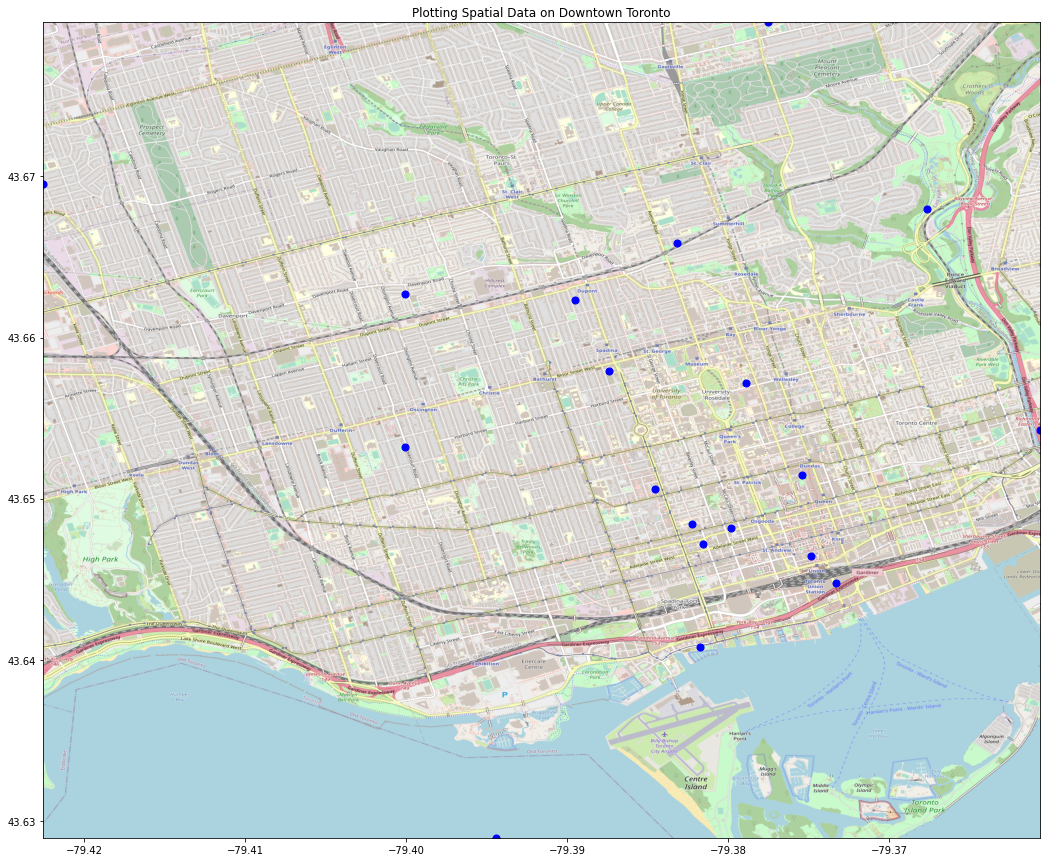

In [13]:
fig, ax = plt.subplots(figsize = (25,15))
ax.scatter(data_Toronto.Longitude, data_Toronto.Latitude, zorder=1, alpha= 1, c='b', s=50)
ax.set_title('Plotting Spatial Data on Downtown Toronto')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

### Transform Latitude and Longitude 


In [14]:
from sklearn.preprocessing import StandardScaler

cluster_dataset_toronto = StandardScaler().fit_transform(data_Toronto[["Latitude","Longitude"]])
pd.DataFrame(cluster_dataset_toronto).head()

,0,1
0,-0.029593,1.760944
1,0.675989,-0.416716
2,0.225024,0.379908
3,-0.272287,0.645472
4,-0.862182,0.804809


### Apllied k-means method

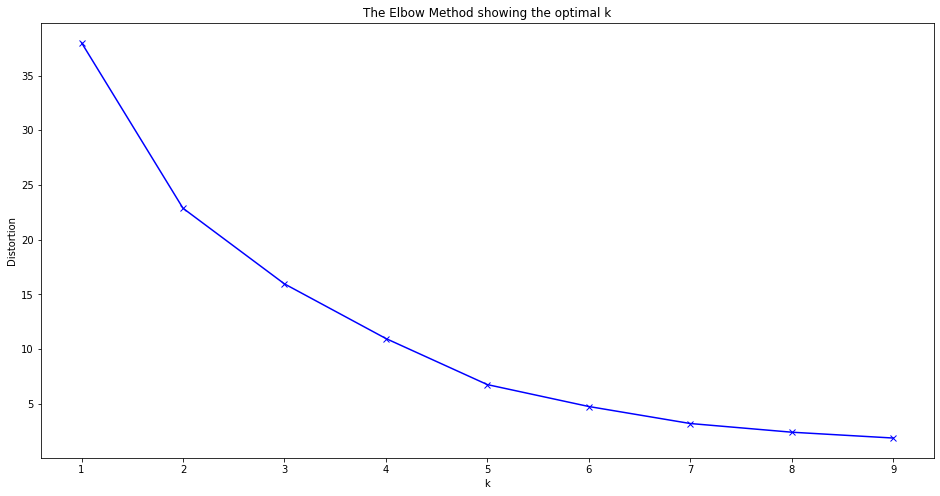

In [15]:
from sklearn.cluster import KMeans 
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(init="k-means++", n_clusters=k, n_init=12)
    kmeanModel.fit(cluster_dataset_toronto)
    distortions.append(kmeanModel.inertia_)

# Plot elbow method    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


### Choosed  k = 4 cluster



In [16]:
k_means = KMeans(init="k-means++", n_clusters=4, n_init=12)
k_means.fit(cluster_dataset_toronto)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Predicted


In [17]:
Clusters = k_means.predict(pd.DataFrame(cluster_dataset_toronto))
Clusters

array([1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 0, 3, 1, 3, 1, 3],
      dtype=int32)

In [20]:
data_Toronto['Cluster'] = Clusters
data_Toronto

,index,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster
0,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1
1,4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2
2,9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1
3,15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1
4,20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1
5,24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1
6,25,M6G,Downtown Toronto,Christie,43.669542,-79.422564,2
7,30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,1
8,36,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,1
9,42,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,1


### Plot scatter with cluster

Text(0.5, 1.0, 'Scatter plot by cluster')

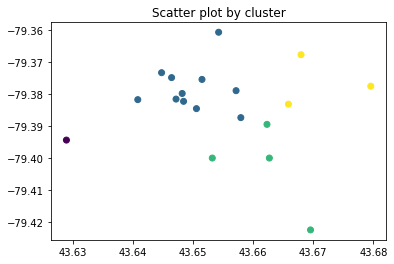

In [21]:
plt.scatter(data_Toronto.Latitude,data_Toronto.Longitude,c=data_Toronto.Cluster)
plt.title("Scatter plot by cluster")